In [1]:
# Data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MODEL
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Some functions used before and after the model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
    classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

# Errors and data representation
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 150)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.simplefilter(action = "ignore")

In [2]:
df_ = pd.read_csv('case_data_set.csv', ";")
df = df_.copy()

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,"29,85","29,85",No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,"56,95","1889,5",No
2,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),"42,3","1840,75",No
3,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),"89,1","1949,4",No
4,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,"29,75","301,9",No


In [4]:
df.drop('customerID', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            5374 non-null   object
 1   SeniorCitizen     5374 non-null   int64 
 2   Partner           5374 non-null   object
 3   Dependents        5374 non-null   object
 4   tenure            5374 non-null   int64 
 5   PhoneService      5374 non-null   object
 6   MultipleLines     5374 non-null   object
 7   InternetService   5374 non-null   object
 8   OnlineSecurity    5374 non-null   object
 9   OnlineBackup      5374 non-null   object
 10  DeviceProtection  5374 non-null   object
 11  TechSupport       5374 non-null   object
 12  StreamingTV       5374 non-null   object
 13  StreamingMovies   5374 non-null   object
 14  Contract          5374 non-null   object
 15  PaperlessBilling  5374 non-null   object
 16  PaymentMethod     5374 non-null   object
 17  MonthlyCharges

In [6]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('O')
df.loc[df["TotalCharges"].isna(),["TotalCharges"]] = '0'

In [7]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
for col in ["MonthlyCharges", "TotalCharges"]:
    df[col] = df[col].apply(lambda x: x.replace(",", "."))
    df = df.astype({col: float})

In [9]:
def grab_cols(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns  # Categorical
                if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns
                   if dataframe[col].nunique() < cat_th and  # Numeric but categorical
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns
                   if dataframe[col].nunique() > car_th and  # Categorical but high cardinal
                   dataframe[col].dtypes == "O"]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes not in ['O', 'datetime64[ns]'] and
                dataframe[col].nunique() > 10]  # Numeric
    return cat_cols, num_but_cat, cat_but_car, num_cols

In [10]:
cat_cols, num_but_cat, cat_but_car, num_cols = grab_cols(df)

In [11]:
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)

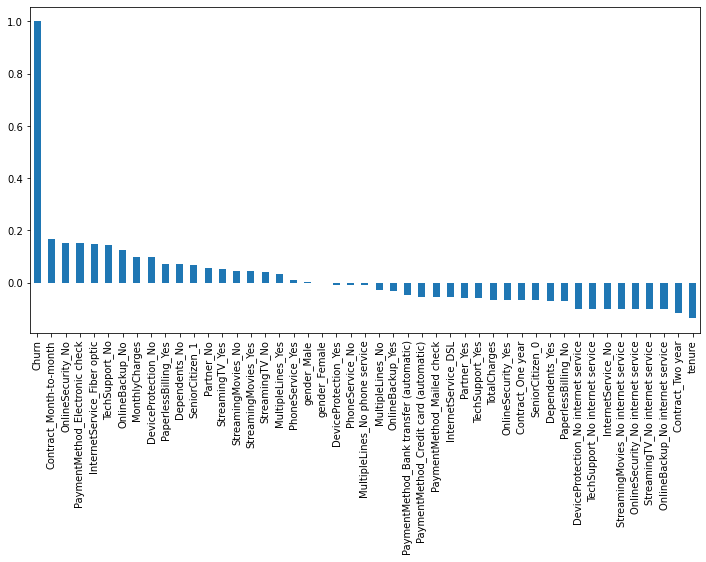

In [12]:
plt.figure(figsize=(12,6))
(pd.get_dummies(df).corr()['Churn']).sort_values(ascending=False).plot(kind='bar');

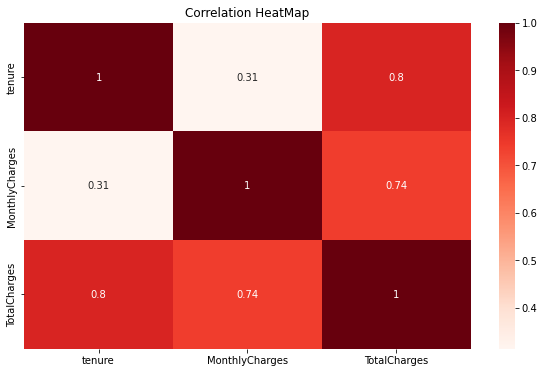

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='Reds')
plt.title('Correlation HeatMap');

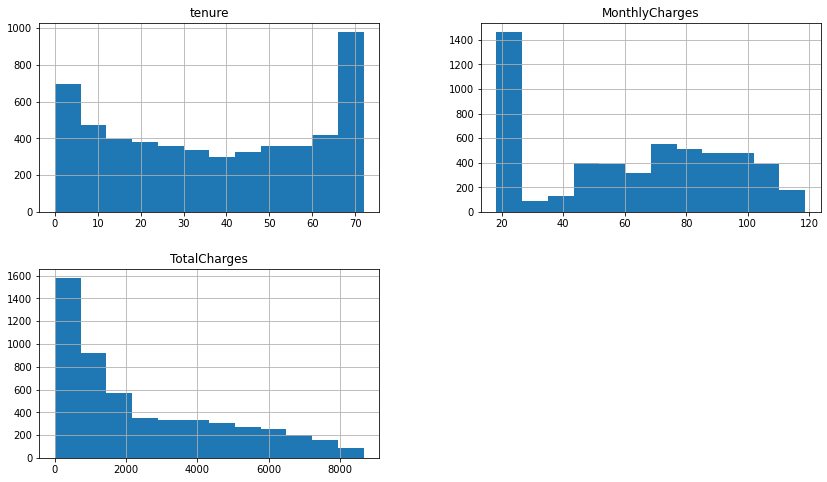

In [14]:
df[num_cols].hist(figsize = (14,8), bins=12);

In [15]:
dummy_diff = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
              'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [16]:
churn_to_contract = df.groupby(['Churn' ,'Contract'])\
.agg({'Contract': 'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_contract.columns = ['Contract', 'Churn_0', 'Churn_1']
churn_to_contract['Churn_Ratio'] = churn_to_contract['Churn_1']*100\
/(churn_to_contract['Churn_0'] + churn_to_contract['Churn_1'])
churn_to_contract

,Contract,Churn_0,Churn_1,Churn_Ratio
0,Month-to-month,2220,173,7.23
1,One year,1307,20,1.51
2,Two year,1647,7,0.42


In [17]:
churn_to_internet = df.groupby(['Churn', 'InternetService']).agg({'InternetService':'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_internet.columns = ['InternetService', 'Churn_0', 'Churn_1']
churn_to_internet['Churn_Ratio'] = churn_to_internet['Churn_1']*100 /(churn_to_internet['Churn_0'] + churn_to_internet['Churn_1'])
churn_to_internet.sort_values(by='Churn_Ratio', ascending=False)

,InternetService,Churn_0,Churn_1,Churn_Ratio
1,Fiber optic,1799,145,7.46
0,DSL,1962,47,2.34
2,No,1413,8,0.56


In [18]:
internet_to_billing = df.groupby(['InternetService', 'PaperlessBilling']).agg({'PaperlessBilling':'count'}).unstack().T.reset_index().drop('level_0', axis=1)
internet_to_billing.columns = ['PaperlessBilling', 'DSL', 'Fiber optic', 'No']
internet_to_billing

,PaperlessBilling,DSL,Fiber optic,No
0,No,941,503,1015
1,Yes,1068,1441,406


In [19]:
churn_to_payment = df.groupby(['Churn', 'PaymentMethod'])\
.agg({'Churn':'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_payment.columns = ['PaymentMethod', 'Churn_0', 'Churn_1']
churn_to_payment['Churn_Ratio'] = churn_to_payment['Churn_1']*100\
/(churn_to_payment['Churn_0'] + churn_to_payment['Churn_1'])
churn_to_payment.sort_values(by='Churn_Ratio', ascending=False)

,PaymentMethod,Churn_0,Churn_1,Churn_Ratio
2,Electronic check,1294,121,8.55
0,Bank transfer (automatic),1286,29,2.21
1,Credit card (automatic),1290,25,1.90
3,Mailed check,1304,25,1.88


In [20]:
churn_to_citizen = df.groupby(['Churn', 'SeniorCitizen']).agg({'Churn':'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_citizen.columns = ['SeniorCitizen', 'Churn_0', 'Churn_1']
churn_to_citizen['Churn_Ratio'] = churn_to_citizen['Churn_1']*100 /(churn_to_citizen['Churn_0'] + churn_to_citizen['Churn_1'])
churn_to_citizen

,SeniorCitizen,Churn_0,Churn_1,Churn_Ratio
0,0,4508,150,3.22
1,1,666,50,6.98


## Outliers

In [21]:
def outliers_threshold(dataframe, column):
    q1 = dataframe[column].quantile(0.05)
    q3 = dataframe[column].quantile(0.95)
    inter_quartile_range = q3 - q1
    low = q1 - 1.5 * inter_quartile_range
    up = q3 + 1.5 * inter_quartile_range
    return low, up

In [22]:
def grab_outlier(dataframe, column, index=False):
    low, up = outliers_threshold(dataframe, column)
    if dataframe[(dataframe[column] < low) |
                 (dataframe[column] > up)].shape[0] < 10:
        print(dataframe[(dataframe[column] < low) | (dataframe[column] > up)])
    else:
        print(dataframe[(dataframe[column] < low) |
                 (dataframe[column] > up)].head())
    if index:
        outlier_index = dataframe[(dataframe[column] < low) |
                                  (dataframe[column] > up)].index
        return outlier_index

In [23]:
for col in num_cols:
    grab_outlier(df[num_cols], col)

Empty DataFrame
Columns: [tenure, MonthlyCharges, TotalCharges]
Index: []
Empty DataFrame
Columns: [tenure, MonthlyCharges, TotalCharges]
Index: []
Empty DataFrame
Columns: [tenure, MonthlyCharges, TotalCharges]
Index: []


## Feature Engineering

In [24]:
df[['tenure', 'MonthlyCharges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5374.00,36.93,24.21,0.00,14.00,37.00,60.00,72.00
MonthlyCharges,5374.00,61.87,30.96,18.25,25.25,65.25,88.90,118.75


### Two next cells create two new features (quantiles instead of num features)

In [25]:
df['new_tenure_segment'] = pd.cut(df['tenure'], bins=[0, 0.5, 30, 60, 100],
                                 labels=['New', 'Low', 'Medium', 'High']).astype('O')

In [26]:
df['new_MonhlyCharges_segment'] = pd.cut(df['MonthlyCharges'], bins=[0, 70, 90, 120],
                                 labels=['Low', 'Medium', 'High']).astype('O')

In [27]:
churn_to_segment = df.groupby(['Churn', 'new_tenure_segment'])\
.agg({'new_tenure_segment': 'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_segment.columns = ['new_tenure_segment', 'Churn_0', 'Churn_1']
churn_to_segment['Churn_Ratio'] = churn_to_segment['Churn_1']*100\
/(churn_to_segment['Churn_0'] + churn_to_segment['Churn_1'])
churn_to_segment.sort_values('Churn_Ratio', ascending=False)

,new_tenure_segment,Churn_0,Churn_1,Churn_Ratio
1,Low,2205,143,6.09
2,Medium,1644,45,2.66
0,High,1314,12,0.90


In [28]:
churn_to_mcharges = df.groupby(['Churn', 'new_MonhlyCharges_segment'])\
.agg({'new_MonhlyCharges_segment': 'count'}).unstack().T.reset_index()\
.drop('level_0', axis=1)
churn_to_mcharges.columns = ['new_MonhlyCharges_segment', 'Churn_0', 'Churn_1']
churn_to_mcharges['Churn_Ratio'] = churn_to_mcharges['Churn_1']*100\
/(churn_to_mcharges['Churn_0'] + churn_to_mcharges['Churn_1'])
churn_to_mcharges.sort_values('Churn_Ratio', ascending=False)

,new_MonhlyCharges_segment,Churn_0,Churn_1,Churn_Ratio
2,Medium,1147,77,6.29
0,High,1169,69,5.57
1,Low,2858,54,1.85


In [30]:
scaler = MinMaxScaler(feature_range=(1, 10))
scaler.fit(df[['tenure', 'MonthlyCharges']])
df[['tenure_scaled', 'MonthlyCharges_scaled']] = scaler\
.transform(df[['tenure', 'MonthlyCharges']])

In [31]:
# New scaled range 1-10
df[['tenure', 'tenure_scaled', 'MonthlyCharges', 'MonthlyCharges_scaled']].head(10)

,tenure,tenure_scaled,MonthlyCharges,MonthlyCharges_scaled
0,1,1.12,29.85,2.04
1,34,5.25,56.95,4.47
2,45,6.62,42.30,3.15
3,22,3.75,89.10,7.34
4,10,2.25,29.75,2.03
5,62,8.75,56.15,4.39
6,13,2.62,49.95,3.84
7,16,3.00,18.95,1.06
8,58,8.25,100.35,8.35
9,25,4.12,105.50,8.81


In [32]:
df['segment_score_1'] = (0.65 * df['tenure_scaled'] + 0.35 * df['MonthlyCharges_scaled'])
df['segment_1'] = pd.qcut(df['segment_score_1'], 5, 
                          labels=['E', 'D', 'C', 'B', 'A']).astype('O')

In [34]:
df[['segment_score_1', 'segment_1']].head(10)

,segment_score_1,segment_1
0,1.44,E
1,4.98,C
2,5.41,C
3,5.01,C
4,2.17,E
5,7.23,B
6,3.05,D
7,2.32,E
8,8.29,A
9,5.77,C


In [35]:
churn_to_segment_1 = df.groupby(['Churn', 'segment_1'])\
.agg({'segment_1':'count'}).unstack().T.reset_index().drop('level_0', axis=1)
churn_to_segment_1.columns = ['segment_1', 'Churn_0', 'Churn_1']
churn_to_segment_1['Churn_Ratio'] = churn_to_segment_1['Churn_1']*100\
/(churn_to_segment_1['Churn_0'] + churn_to_segment_1['Churn_1'])
churn_to_segment_1.sort_values('Churn_Ratio', ascending=True)

,segment_1,Churn_0,Churn_1,Churn_Ratio
0,A,1055,20,1.86
1,B,1051,24,2.23
2,C,1034,40,3.72
4,E,1034,41,3.81
3,D,1000,75,6.98


In [36]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'new_tenure_segment', 'new_MonhlyCharges_segment', 'tenure_scaled', 'MonthlyCharges_scaled',
       'segment_score_1', 'segment_1'],
      dtype='object')

In [37]:
# I'll drop these columns. I won't use them anymore.
df.drop(['tenure_scaled', 'segment_score_1', 'MonthlyCharges_scaled', 'tenure', 'MonthlyCharges'], 
        axis=1, inplace=True)

In [38]:
df['Churn'] = df['Churn'].astype('O')

In [39]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [40]:
multi_col = [col for col in df.columns if df[col].nunique() > 2 and df[col].dtypes == 'O']
multi_col

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'new_tenure_segment',
 'new_MonhlyCharges_segment',
 'segment_1']

In [41]:
num_col = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_col

['TotalCharges']

In [42]:
def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [43]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols,
                               drop_first=drop_first)
    return dataframe

In [44]:
for col in binary_cols:
    label_encoder(df, col)

In [45]:
# These columns include same information that are no internet service and no phone service
dummy_diff = ['OnlineSecurity', 'OnlineBackup', 
              'DeviceProtection', 'TechSupport', 
              'StreamingTV', 'StreamingMovies', 
              'MultipleLines']

Get dummies only for the columns with duplications (we then remove duplications)

In [46]:
df = one_hot_encoder(df, dummy_diff, drop_first=False)

In [47]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn,new_tenure_segment,new_MonhlyCharges_segment,segment_1,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,0,DSL,Month-to-month,1,Electronic check,29.85,0,Low,Low,E,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
1,1,0,0,0,1,DSL,One year,0,Mailed check,1889.50,0,Medium,Low,C,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
2,1,0,0,0,0,DSL,One year,0,Bank transfer (automatic),1840.75,0,Medium,Low,C,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0
3,1,0,0,1,1,Fiber optic,Month-to-month,1,Credit card (automatic),1949.40,0,Low,Medium,C,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1
4,0,0,0,0,0,DSL,Month-to-month,0,Mailed check,301.90,0,Low,Low,E,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [48]:
drop_list = df.columns[df.columns.str.contains(pat = 'No internet service')].to_list()
drop_list.append('MultipleLines_No phone service')
drop_list

['OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'MultipleLines_No phone service']

In [49]:
df.drop(drop_list, axis=1, inplace=True)

In [52]:
dummy = list(set(multi_col) - set(dummy_diff))
dummy

['new_MonhlyCharges_segment',
 'InternetService',
 'Contract',
 'PaymentMethod',
 'new_tenure_segment',
 'segment_1']

In [54]:
df = one_hot_encoder(df, dummy, drop_first=True)

In [55]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,TotalCharges,Churn,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes,new_MonhlyCharges_segment_Low,new_MonhlyCharges_segment_Medium,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,new_tenure_segment_Low,new_tenure_segment_Medium,segment_1_B,segment_1_C,segment_1_D,segment_1_E
0,0,0,1,0,0,1,29.85,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,1,0,0,0,1,0,1889.50,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,1,0,0,0,0,0,1840.75,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,1,0,0,1,1,1,1949.40,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,301.90,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1


## Split Data

In [57]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)

In [58]:
scaler = StandardScaler().fit(X_train[num_col])
X_train[num_col] = scaler.transform(X_train[num_col])

scaler = StandardScaler().fit(X_test[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [59]:
X_train.shape, X_test.shape

((4030, 36), (1344, 36))

## Model

### Balance targets

In [61]:
print(' Churn No Ratio: ', round(df['Churn'].value_counts()[0]/df.shape[0] ,2), '\n', 
      'Churn Yes Ratio: ', round(df['Churn'].value_counts()[1]/df.shape[0] ,2))

 Churn No Ratio:  0.96 
 Churn Yes Ratio:  0.04


In [64]:
models = [('LR', LogisticRegression(solver='liblinear')),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVC', SVC(gamma='auto')),
          ('GB',GradientBoostingClassifier())]

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.962596 (0.007096)
KNN: 0.962409 (0.007117)
CART: 0.928356 (0.007485)
RF: 0.959618 (0.007082)
SVC: 0.962782 (0.007172)
GB: 0.960176 (0.006943)


## Logistic Regression

In [65]:
loj = LogisticRegression(solver='liblinear')
loj_model = loj.fit(X_train, y_train)
y_pred = loj_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1295,    0],
       [  49,    0]])

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1295
           1       0.00      0.00      0.00        49

    accuracy                           0.96      1344
   macro avg       0.48      0.50      0.49      1344
weighted avg       0.93      0.96      0.95      1344



In [131]:
LR = [0.96, 0.96, 1.0, 0.98, 0.0, 0.0, 0.0]

In [68]:
cross_val_score(loj_model, X_test, y_test, cv=10).mean() # Model Tuned

0.963543394140409

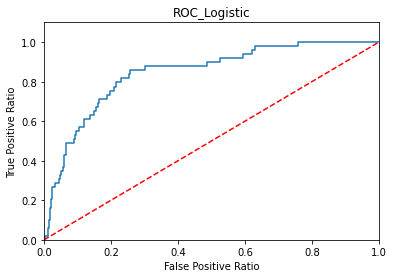

In [69]:
logit_roc_auc = roc_auc_score(y_test, loj_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, loj_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC_Logistic')
plt.show();

## GB (GRADIENT BOOSTING)

In [72]:
gbm_params = {"learning_rate" : [0.01, 0.05, 0.1],
             "n_estimators": [100],
             "max_depth": [3,5],
             "min_samples_split": [5,10]}

gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [73]:
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END learning_rate=0.01, max_dept

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5], 'min_samples_split': [5, 10],
                         'n_estimators': [100]},
             verbose=2)

In [74]:
print('Best scor : ' + str(gbm_cv.best_score_))
print('Best parameters : ' + str(gbm_cv.best_params_))

Best scor : 0.962531017369727
Best parameters : {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [75]:
gbm_tuned = GradientBoostingClassifier(learning_rate=0.01,
                                      max_depth=3,
                                      min_samples_split=5,
                                      n_estimators=100)
gbm_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_split=5)

In [76]:
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred) # Model Tuned

0.9635416666666666

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1295
           1       0.00      0.00      0.00        49

    accuracy                           0.96      1344
   macro avg       0.48      0.50      0.49      1344
weighted avg       0.93      0.96      0.95      1344



In [132]:
GB = [0.96, 0.96, 1.0, 0.98, 0.0, 0.0, 0.0]

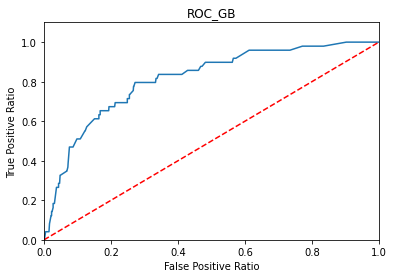

In [79]:
logit_roc_auc = roc_auc_score(y_test, gbm_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbm_tuned.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC_GB')
plt.show()

In [133]:
conclusion_1 = pd.DataFrame({'LR': LR,
                             'GB': GB}, index=['accuracy', 'precision_0', 
                                               'recall_0', 'f_1_score_0',
                                               'precision_1', 'recall_1', 
                                               'f_1_score_1']).T

## Model With Sample

In [94]:
df = df_.copy()

In [95]:
df.drop('customerID', axis=1, inplace=True)
df_1 = df[df['Churn'] == 'No'].sample(n=200, random_state=1)
df_2 = df[df['Churn'] == 'Yes']
df = pd.concat([df_1, df_2]).reset_index(drop=True)

In [96]:
df['Churn'].value_counts()

No     200
Yes    200
Name: Churn, dtype: int64

In [97]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('O')
df.loc[df["TotalCharges"].isna(),["TotalCharges"]] = '0'

In [98]:
for col in ["MonthlyCharges", "TotalCharges"]:
    df[col] = df[col].apply(lambda x: x.replace(",", "."))
    df = df.astype({col: float})

In [99]:
cat_col = [col for col in df.columns if df[col].dtypes == 'O']
num_col = [col for col in df.columns if df[col].dtypes != 'O']

In [100]:
cat_col

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [101]:
num_col

['tenure', 'MonthlyCharges', 'TotalCharges']

### Feature Engineering

In [102]:
df['new_tenure_segment'] = pd.cut(df['tenure'], bins=[0, 0.5, 30, 60, 100],
                                 labels=['New', 'Low', 'Medium', 'High']).astype('O')
df['new_MonhlyCharges_segment'] = pd.cut(df['MonthlyCharges'], bins=[0, 70, 90, 120],
                                 labels=['Low', 'Medium', 'High']).astype('O')

In [103]:
scaler = MinMaxScaler(feature_range=(1, 10))
scaler.fit(df[['tenure', 'MonthlyCharges']])
df[['tenure_scaled', 'MonthlyCharges_scaled']] = scaler.transform(df[['tenure', 'MonthlyCharges']])
df['segment_score_1'] = (0.65 * df['tenure_scaled'] + 0.35 * df['MonthlyCharges_scaled'])
df['segment_1'] = pd.qcut(df['segment_score_1'], 5, labels=['E', 'D', 'C', 'B', 'A']).astype('O')
df.drop(['tenure_scaled', 'segment_score_1', 'MonthlyCharges_scaled',
        'tenure', 'MonthlyCharges'], axis=1, inplace=True)

In [104]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
multi_col = [col for col in df.columns if df[col].nunique() > 2 and df[col].dtypes == 'O']
num_col = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]

In [105]:
for col in binary_cols:
    label_encoder(df, col)

In [106]:
df = one_hot_encoder(df, dummy_diff, drop_first=False)
drop_list = df.columns[df.columns.str.contains(pat = 'No internet service')].to_list()
drop_list.append('MultipleLines_No phone service')
df.drop(drop_list, axis=1, inplace=True)
df = one_hot_encoder(df, dummy, drop_first=True)

In [107]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [108]:
num_col = ['TotalCharges']

In [109]:
scaler = StandardScaler().fit(X_train[num_col])
X_train[num_col] = scaler.transform(X_train[num_col])
scaler = StandardScaler().fit(X_test[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

### Logistic Regression

In [111]:
loj = LogisticRegression(solver='liblinear')
loj_model = loj.fit(X_train, y_train)
y_pred = loj_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[39, 13],
       [14, 34]])

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74        52
           1       0.72      0.71      0.72        48

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.73      0.73      0.73       100



In [128]:
LR = [0.73, 0.74, 0.75, 0.74, 0.72, 0.71, 0.72]

In [114]:
cross_val_score(loj_model, X_test, y_test, cv=10).mean() # Tuned Model

0.72

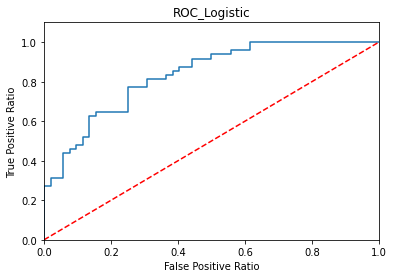

In [115]:
logit_roc_auc = roc_auc_score(y_test, loj_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, loj_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC_Logistic')
plt.show()

### GB (Gradient Boosting)

In [116]:
gbm_params = {"learning_rate" : [0.01, 0.05, 0.1],
             "n_estimators": [100],
             "max_depth": [3,5],
             "min_samples_split": [5,10]}

gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [117]:
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_dept

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5], 'min_samples_split': [5, 10],
                         'n_estimators': [100]},
             verbose=2)

In [118]:
print('Best score : ' + str(gbm_cv.best_score_))
print('Best parameters : ' + str(gbm_cv.best_params_))

Best score : 0.76
Best parameters : {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [119]:
gbm_tuned = GradientBoostingClassifier(learning_rate=0.05,
                                      max_depth=3,
                                      min_samples_split=10,
                                      n_estimators=100)
gbm_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, min_samples_split=10)

In [120]:
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred) # Model Tuned

0.68

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        52
           1       0.68      0.62      0.65        48

    accuracy                           0.68       100
   macro avg       0.68      0.68      0.68       100
weighted avg       0.68      0.68      0.68       100



In [127]:
GB = [0.68, 0.68, 0.73, 0.70, 0.68, 0.62, 0.65]

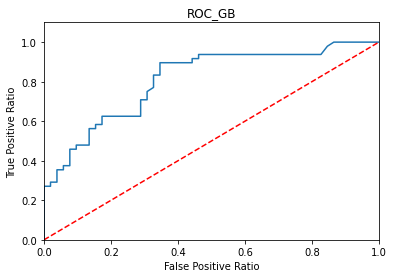

In [123]:
logit_roc_auc = roc_auc_score(y_test, gbm_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbm_tuned.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC_GB')
plt.show();

In [129]:
conclusion_2 = pd.DataFrame({'LR': LR,
                        'GB': GB,}, index=['accuracy', 'precision_0', 
                                        'recall_0', 'f_1_score_0',
                                        'precision_1', 'recall_1', 
                                        'f_1_score_1']).T

In [134]:
conclusion_1

,accuracy,precision_0,recall_0,f_1_score_0,precision_1,recall_1,f_1_score_1
LR,0.96,0.96,1.00,0.98,0.00,0.00,0.00
GB,0.96,0.96,1.00,0.98,0.00,0.00,0.00


In [130]:
conclusion_2

,accuracy,precision_0,recall_0,f_1_score_0,precision_1,recall_1,f_1_score_1
LR,0.73,0.74,0.75,0.74,0.72,0.71,0.72
GB,0.68,0.68,0.73,0.70,0.68,0.62,0.65


In [137]:
y_pred_proba = loj_model.predict_proba(X_test)
y_pred_proba

array([[0.32347819, 0.67652181],
       [0.12028207, 0.87971793],
       [0.14107287, 0.85892713],
       [0.93066093, 0.06933907],
       [0.86996585, 0.13003415],
       [0.57483675, 0.42516325],
       [0.15648355, 0.84351645],
       [0.53245458, 0.46754542],
       [0.43938368, 0.56061632],
       [0.33290617, 0.66709383],
       [0.16320224, 0.83679776],
       [0.31284007, 0.68715993],
       [0.45981019, 0.54018981],
       [0.94986817, 0.05013183],
       [0.10644212, 0.89355788],
       [0.29268049, 0.70731951],
       [0.08151343, 0.91848657],
       [0.97580672, 0.02419328],
       [0.36812585, 0.63187415],
       [0.98544337, 0.01455663],
       [0.37431499, 0.62568501],
       [0.44026478, 0.55973522],
       [0.32633258, 0.67366742],
       [0.32354696, 0.67645304],
       [0.57598346, 0.42401654],
       [0.20074032, 0.79925968],
       [0.8910834 , 0.1089166 ],
       [0.21511854, 0.78488146],
       [0.4995285 , 0.5004715 ],
       [0.80369086, 0.19630914],
       [0.

In [139]:
y_pred_proba_yes = y_pred_proba[:,1]
y_pred_proba_yes

array([0.67652181, 0.87971793, 0.85892713, 0.06933907, 0.13003415,
       0.42516325, 0.84351645, 0.46754542, 0.56061632, 0.66709383,
       0.83679776, 0.68715993, 0.54018981, 0.05013183, 0.89355788,
       0.70731951, 0.91848657, 0.02419328, 0.63187415, 0.01455663,
       0.62568501, 0.55973522, 0.67366742, 0.67645304, 0.42401654,
       0.79925968, 0.1089166 , 0.78488146, 0.5004715 , 0.19630914,
       0.17217375, 0.08950552, 0.17572316, 0.43044696, 0.7501276 ,
       0.36048975, 0.84340977, 0.66373807, 0.66530198, 0.0784084 ,
       0.41729361, 0.69218747, 0.04367235, 0.14496323, 0.91499924,
       0.5404082 , 0.07515367, 0.53288324, 0.32476635, 0.04586219,
       0.93242314, 0.15793462, 0.80876093, 0.51283986, 0.88958562,
       0.47250124, 0.37036198, 0.08383758, 0.16771428, 0.12399785,
       0.12364438, 0.78670028, 0.19868923, 0.41273574, 0.947256  ,
       0.57523788, 0.9227779 , 0.27515154, 0.01510096, 0.49161131,
       0.23603741, 0.06980274, 0.05977912, 0.37085327, 0.05855

In [145]:
rank = pd.DataFrame(y_test)
rank['PredProbaYes'] = y_pred_proba_yes
rank

,Churn,PredProbaYes
38,0,0.68
387,1,0.88
270,1,0.86
181,0,0.07
195,0,0.13
...,...,...
241,1,0.28
168,0,0.23
243,1,0.77
363,1,0.92


In [150]:
rank.sort_values("PredProbaYes", ascending=False).head(20)

,Churn,PredProbaYes
354,1,0.97
283,1,0.95
246,1,0.95
353,1,0.93
256,1,0.92
363,1,0.92
302,1,0.92
320,1,0.91
374,1,0.89
334,1,0.89
